# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

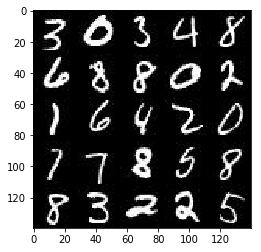

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

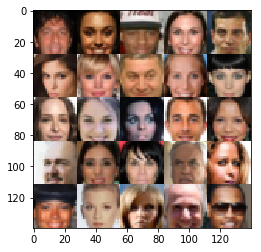

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='inputs_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return inputs_real, inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        #input layer 28 * 28 * 3
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2,256,5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4*256
        
        #Flatten
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits,rate=0.2)
        
        out = tf.sigmoid(logits)
        
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=(not is_train)):
        alpha = 0.2
        
        # Fully connected layer
        x1 = tf.layers.dense(z, 6*6*256)
        

        # Reshape it to start conv
        x1 = tf.reshape(x1,(-1,6,6,256))
        
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 6x6x512 now

        x2 = tf.layers.conv2d_transpose(x1,128,4,strides=2,padding='valid')        
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        x2 = tf.layers.conv2d_transpose(x2,64,5,strides=1,padding='same')        
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256

        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,2,strides=2,padding='valid')
        # 28*28*channel_dim now

        logits = tf.layers.dropout(logits,rate=0.2)
        out = tf.tanh(logits)    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #print(out_channel_dim)
    g_model = generator(input_z,out_channel_dim=out_channel_dim)
    #print(g_model.shape)
    d_model_real,d_logits_real = discriminator(input_real)
    #print(input_real.shape)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss,g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph();
    # print(z_dim)
    out_channel_dim = data_shape[3]
    
    input_real,input_z,lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss,g_loss,learning_rate,beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1,1,size=(72,z_dim))
    samples,losses = [],[]
    
    # TODO: Train Model
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # batch images are scaled [-.5 , .5]  multiplying by 2 to scale to -1, 1
                batch_images *= 2
                
                # sample random noise for Generator
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images , input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every ==0:
                    train_loss_d = d_loss.eval({input_z: batch_z,input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1,epochs),
                          "Discriminator loss:{:.4f}...".format(train_loss_d),
                          "Generator loss:{:.4f}".format(train_loss_g))
                    
                if steps % show_every ==0:
                    show_generator_output(sess,25,input_z,out_channel_dim=out_channel_dim,image_mode=data_image_mode)
        saver.save(sess,'./checkpoints/generator.ckpt')            
        
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator loss:0.1724... Generator loss:2.1140
Epoch 1/2... Discriminator loss:0.0568... Generator loss:3.4959
Epoch 1/2... Discriminator loss:0.0557... Generator loss:3.4117
Epoch 1/2... Discriminator loss:3.7336... Generator loss:0.1968
Epoch 1/2... Discriminator loss:0.2957... Generator loss:2.9402
Epoch 1/2... Discriminator loss:0.1866... Generator loss:5.6672
Epoch 1/2... Discriminator loss:0.5572... Generator loss:1.1208
Epoch 1/2... Discriminator loss:1.5355... Generator loss:0.5609
Epoch 1/2... Discriminator loss:1.4230... Generator loss:3.8772
Epoch 1/2... Discriminator loss:0.6030... Generator loss:3.0130


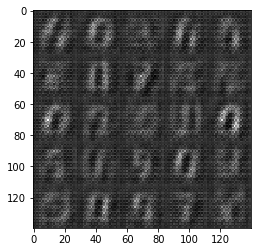

Epoch 1/2... Discriminator loss:2.0735... Generator loss:6.1827
Epoch 1/2... Discriminator loss:0.5625... Generator loss:1.7122
Epoch 1/2... Discriminator loss:1.1760... Generator loss:0.6422
Epoch 1/2... Discriminator loss:1.1199... Generator loss:2.1498
Epoch 1/2... Discriminator loss:0.9357... Generator loss:0.8989
Epoch 1/2... Discriminator loss:0.7694... Generator loss:1.3159
Epoch 1/2... Discriminator loss:1.0756... Generator loss:0.5926
Epoch 1/2... Discriminator loss:0.6437... Generator loss:1.2916
Epoch 1/2... Discriminator loss:0.6345... Generator loss:1.3748
Epoch 1/2... Discriminator loss:0.6413... Generator loss:1.8295


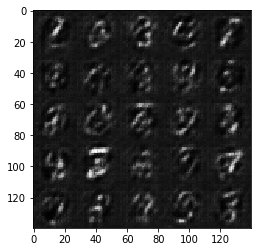

Epoch 1/2... Discriminator loss:0.9132... Generator loss:0.6509
Epoch 1/2... Discriminator loss:0.6936... Generator loss:2.7774
Epoch 1/2... Discriminator loss:0.9834... Generator loss:0.6199
Epoch 1/2... Discriminator loss:2.2523... Generator loss:5.0918
Epoch 1/2... Discriminator loss:0.6585... Generator loss:1.2181
Epoch 1/2... Discriminator loss:0.4851... Generator loss:1.7160
Epoch 1/2... Discriminator loss:0.6084... Generator loss:1.2455
Epoch 1/2... Discriminator loss:0.5765... Generator loss:1.1840
Epoch 1/2... Discriminator loss:1.0327... Generator loss:0.5934
Epoch 1/2... Discriminator loss:0.6173... Generator loss:1.1389


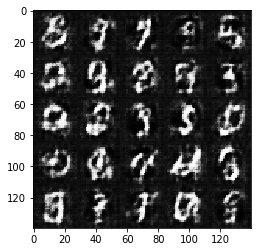

Epoch 1/2... Discriminator loss:1.2430... Generator loss:3.7915
Epoch 1/2... Discriminator loss:0.8420... Generator loss:0.7188
Epoch 1/2... Discriminator loss:0.7066... Generator loss:0.9409
Epoch 1/2... Discriminator loss:0.6103... Generator loss:2.2594
Epoch 1/2... Discriminator loss:2.8205... Generator loss:0.0842
Epoch 1/2... Discriminator loss:0.6089... Generator loss:1.9275
Epoch 1/2... Discriminator loss:1.9357... Generator loss:4.7036
Epoch 1/2... Discriminator loss:0.5294... Generator loss:1.5866
Epoch 1/2... Discriminator loss:0.6522... Generator loss:1.8629
Epoch 1/2... Discriminator loss:0.7210... Generator loss:0.9134


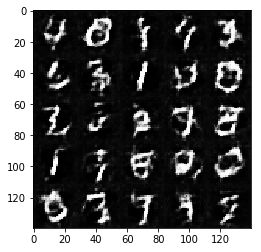

Epoch 1/2... Discriminator loss:0.6174... Generator loss:1.2541
Epoch 1/2... Discriminator loss:0.5901... Generator loss:1.3119
Epoch 1/2... Discriminator loss:0.9655... Generator loss:0.8431
Epoch 1/2... Discriminator loss:0.6575... Generator loss:1.0090
Epoch 1/2... Discriminator loss:0.6252... Generator loss:1.2564
Epoch 1/2... Discriminator loss:0.6923... Generator loss:1.0999
Epoch 1/2... Discriminator loss:0.7554... Generator loss:0.8688
Epoch 1/2... Discriminator loss:0.9519... Generator loss:2.6973
Epoch 1/2... Discriminator loss:0.8726... Generator loss:0.7266
Epoch 1/2... Discriminator loss:0.6995... Generator loss:1.0818


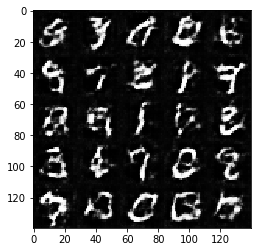

Epoch 1/2... Discriminator loss:1.0808... Generator loss:0.5841
Epoch 1/2... Discriminator loss:0.8091... Generator loss:0.8442
Epoch 1/2... Discriminator loss:0.8676... Generator loss:2.4606
Epoch 1/2... Discriminator loss:0.7797... Generator loss:0.8579
Epoch 1/2... Discriminator loss:0.7355... Generator loss:1.0139
Epoch 1/2... Discriminator loss:0.7532... Generator loss:1.2371
Epoch 1/2... Discriminator loss:1.0794... Generator loss:0.5604
Epoch 1/2... Discriminator loss:0.8295... Generator loss:1.3323
Epoch 1/2... Discriminator loss:1.9108... Generator loss:3.5210
Epoch 1/2... Discriminator loss:0.9433... Generator loss:1.7582


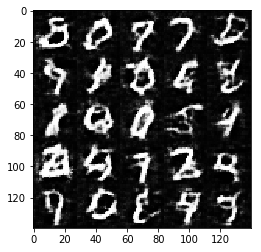

Epoch 1/2... Discriminator loss:1.0121... Generator loss:0.6557
Epoch 1/2... Discriminator loss:1.0966... Generator loss:0.5652
Epoch 1/2... Discriminator loss:0.7960... Generator loss:1.2949
Epoch 1/2... Discriminator loss:0.7509... Generator loss:1.2076
Epoch 1/2... Discriminator loss:0.7277... Generator loss:1.2410
Epoch 1/2... Discriminator loss:1.5514... Generator loss:0.2994
Epoch 1/2... Discriminator loss:0.8838... Generator loss:0.7820
Epoch 1/2... Discriminator loss:0.8810... Generator loss:0.7703
Epoch 1/2... Discriminator loss:0.7109... Generator loss:1.5866
Epoch 1/2... Discriminator loss:0.6598... Generator loss:1.7206


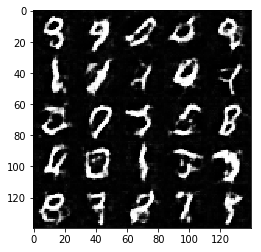

Epoch 1/2... Discriminator loss:1.4640... Generator loss:2.1219
Epoch 1/2... Discriminator loss:0.8246... Generator loss:1.1151
Epoch 1/2... Discriminator loss:1.0693... Generator loss:0.6296
Epoch 1/2... Discriminator loss:0.8645... Generator loss:0.8096
Epoch 1/2... Discriminator loss:1.5558... Generator loss:0.4001
Epoch 1/2... Discriminator loss:0.9132... Generator loss:0.9776
Epoch 1/2... Discriminator loss:0.9447... Generator loss:0.8459
Epoch 1/2... Discriminator loss:0.9658... Generator loss:0.6770
Epoch 1/2... Discriminator loss:1.0531... Generator loss:1.9593
Epoch 1/2... Discriminator loss:1.0144... Generator loss:0.6721


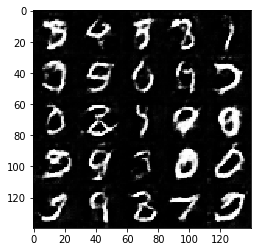

Epoch 1/2... Discriminator loss:0.9711... Generator loss:1.2119
Epoch 1/2... Discriminator loss:1.2551... Generator loss:2.1659
Epoch 1/2... Discriminator loss:0.7342... Generator loss:0.9578
Epoch 1/2... Discriminator loss:0.8082... Generator loss:2.0623
Epoch 1/2... Discriminator loss:2.3517... Generator loss:3.4918
Epoch 1/2... Discriminator loss:1.1121... Generator loss:0.6849
Epoch 1/2... Discriminator loss:0.8369... Generator loss:0.8293
Epoch 1/2... Discriminator loss:0.8015... Generator loss:1.1868
Epoch 1/2... Discriminator loss:1.2206... Generator loss:2.3078
Epoch 1/2... Discriminator loss:0.8265... Generator loss:0.9359


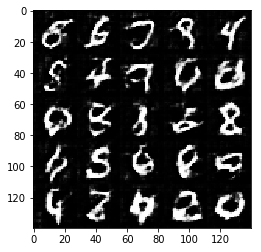

Epoch 1/2... Discriminator loss:0.9964... Generator loss:0.7692
Epoch 1/2... Discriminator loss:0.7429... Generator loss:1.2693
Epoch 1/2... Discriminator loss:0.8363... Generator loss:0.9696
Epoch 2/2... Discriminator loss:1.4537... Generator loss:0.3496
Epoch 2/2... Discriminator loss:1.2024... Generator loss:0.5026
Epoch 2/2... Discriminator loss:0.7566... Generator loss:1.0071
Epoch 2/2... Discriminator loss:0.9587... Generator loss:0.6988
Epoch 2/2... Discriminator loss:0.7699... Generator loss:1.1240
Epoch 2/2... Discriminator loss:1.3071... Generator loss:0.4710
Epoch 2/2... Discriminator loss:0.9186... Generator loss:0.9172


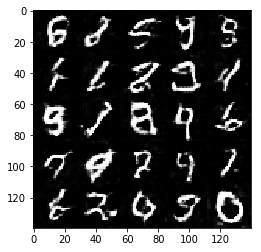

Epoch 2/2... Discriminator loss:1.0566... Generator loss:0.6220
Epoch 2/2... Discriminator loss:0.6507... Generator loss:1.0832
Epoch 2/2... Discriminator loss:1.2473... Generator loss:1.7099
Epoch 2/2... Discriminator loss:0.6695... Generator loss:1.9168
Epoch 2/2... Discriminator loss:0.9187... Generator loss:0.8181
Epoch 2/2... Discriminator loss:1.0546... Generator loss:0.6176
Epoch 2/2... Discriminator loss:1.0623... Generator loss:0.6057
Epoch 2/2... Discriminator loss:1.0298... Generator loss:0.7735
Epoch 2/2... Discriminator loss:1.3510... Generator loss:0.3999
Epoch 2/2... Discriminator loss:0.9684... Generator loss:0.6996


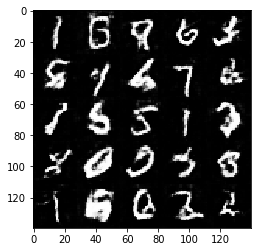

Epoch 2/2... Discriminator loss:0.7010... Generator loss:1.1078
Epoch 2/2... Discriminator loss:0.7159... Generator loss:1.4239
Epoch 2/2... Discriminator loss:0.7759... Generator loss:1.2558
Epoch 2/2... Discriminator loss:2.4249... Generator loss:3.7552
Epoch 2/2... Discriminator loss:0.8076... Generator loss:1.3909
Epoch 2/2... Discriminator loss:0.8334... Generator loss:0.8453
Epoch 2/2... Discriminator loss:1.4368... Generator loss:0.3930
Epoch 2/2... Discriminator loss:1.1837... Generator loss:1.3942
Epoch 2/2... Discriminator loss:1.1183... Generator loss:0.6989
Epoch 2/2... Discriminator loss:1.1758... Generator loss:0.5585


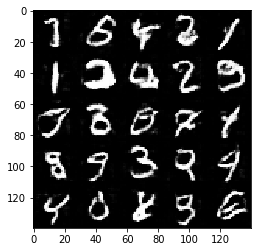

Epoch 2/2... Discriminator loss:0.7500... Generator loss:1.0695
Epoch 2/2... Discriminator loss:1.5248... Generator loss:2.8911
Epoch 2/2... Discriminator loss:0.7996... Generator loss:1.2842
Epoch 2/2... Discriminator loss:1.0902... Generator loss:0.6180
Epoch 2/2... Discriminator loss:0.7050... Generator loss:1.5659
Epoch 2/2... Discriminator loss:1.3263... Generator loss:0.4207
Epoch 2/2... Discriminator loss:0.8138... Generator loss:1.0148
Epoch 2/2... Discriminator loss:1.2276... Generator loss:0.4914
Epoch 2/2... Discriminator loss:0.8407... Generator loss:1.0917
Epoch 2/2... Discriminator loss:0.7207... Generator loss:1.0418


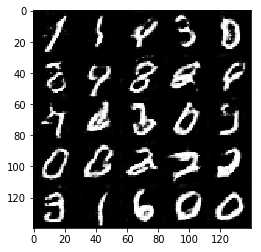

Epoch 2/2... Discriminator loss:0.7049... Generator loss:1.2100
Epoch 2/2... Discriminator loss:1.1076... Generator loss:0.5409
Epoch 2/2... Discriminator loss:1.0192... Generator loss:0.9478
Epoch 2/2... Discriminator loss:0.7073... Generator loss:1.2958
Epoch 2/2... Discriminator loss:1.0963... Generator loss:0.6090
Epoch 2/2... Discriminator loss:1.8336... Generator loss:0.2564
Epoch 2/2... Discriminator loss:1.0414... Generator loss:0.6529
Epoch 2/2... Discriminator loss:1.2029... Generator loss:0.5041
Epoch 2/2... Discriminator loss:0.7071... Generator loss:1.2550
Epoch 2/2... Discriminator loss:1.2668... Generator loss:0.4805


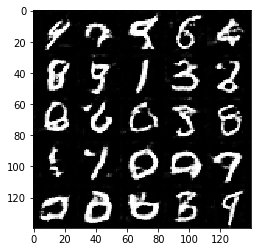

Epoch 2/2... Discriminator loss:1.4837... Generator loss:0.3925
Epoch 2/2... Discriminator loss:0.9262... Generator loss:0.8094
Epoch 2/2... Discriminator loss:1.1390... Generator loss:0.5193
Epoch 2/2... Discriminator loss:1.5014... Generator loss:0.4178
Epoch 2/2... Discriminator loss:1.0967... Generator loss:0.5849
Epoch 2/2... Discriminator loss:0.9898... Generator loss:2.4811
Epoch 2/2... Discriminator loss:0.9013... Generator loss:0.6939
Epoch 2/2... Discriminator loss:0.8500... Generator loss:0.9795
Epoch 2/2... Discriminator loss:0.8134... Generator loss:1.0111
Epoch 2/2... Discriminator loss:0.7480... Generator loss:1.0829


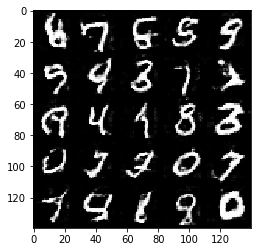

Epoch 2/2... Discriminator loss:1.0330... Generator loss:0.6254
Epoch 2/2... Discriminator loss:1.0064... Generator loss:0.7371
Epoch 2/2... Discriminator loss:2.1966... Generator loss:0.2007
Epoch 2/2... Discriminator loss:0.7733... Generator loss:0.9825
Epoch 2/2... Discriminator loss:0.6493... Generator loss:1.1766
Epoch 2/2... Discriminator loss:0.8474... Generator loss:1.8077
Epoch 2/2... Discriminator loss:0.8174... Generator loss:0.9184
Epoch 2/2... Discriminator loss:0.5315... Generator loss:1.2488
Epoch 2/2... Discriminator loss:3.1817... Generator loss:0.1199
Epoch 2/2... Discriminator loss:0.8184... Generator loss:2.1544


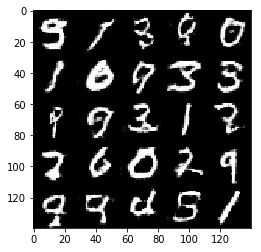

Epoch 2/2... Discriminator loss:0.7426... Generator loss:1.6626
Epoch 2/2... Discriminator loss:0.6395... Generator loss:1.5392
Epoch 2/2... Discriminator loss:0.7497... Generator loss:1.6685
Epoch 2/2... Discriminator loss:0.8554... Generator loss:0.9280
Epoch 2/2... Discriminator loss:0.6642... Generator loss:1.2289
Epoch 2/2... Discriminator loss:0.7939... Generator loss:0.8395
Epoch 2/2... Discriminator loss:0.9585... Generator loss:0.7385
Epoch 2/2... Discriminator loss:0.9541... Generator loss:0.9375
Epoch 2/2... Discriminator loss:0.6946... Generator loss:1.6215
Epoch 2/2... Discriminator loss:1.2625... Generator loss:0.4970


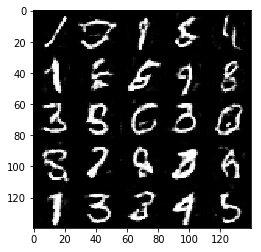

Epoch 2/2... Discriminator loss:0.9928... Generator loss:1.6524
Epoch 2/2... Discriminator loss:1.0165... Generator loss:0.7863
Epoch 2/2... Discriminator loss:0.9397... Generator loss:0.7976
Epoch 2/2... Discriminator loss:0.8210... Generator loss:0.9041
Epoch 2/2... Discriminator loss:0.8901... Generator loss:0.8022
Epoch 2/2... Discriminator loss:1.1688... Generator loss:2.3604
Epoch 2/2... Discriminator loss:0.7364... Generator loss:1.0201
Epoch 2/2... Discriminator loss:0.8581... Generator loss:1.0858
Epoch 2/2... Discriminator loss:1.0197... Generator loss:0.5767
Epoch 2/2... Discriminator loss:1.0620... Generator loss:0.6708


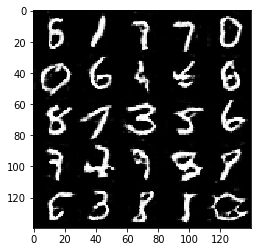

Epoch 2/2... Discriminator loss:0.7829... Generator loss:1.8040
Epoch 2/2... Discriminator loss:1.6598... Generator loss:0.3163
Epoch 2/2... Discriminator loss:1.0373... Generator loss:0.6321
Epoch 2/2... Discriminator loss:0.7032... Generator loss:1.0263
Epoch 2/2... Discriminator loss:0.8528... Generator loss:0.9044
Epoch 2/2... Discriminator loss:0.6972... Generator loss:1.1585
Epoch 2/2... Discriminator loss:1.0099... Generator loss:0.6455


In [67]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator loss:0.0578... Generator loss:4.7869
Epoch 1/1... Discriminator loss:0.8038... Generator loss:20.3850
Epoch 1/1... Discriminator loss:2.0341... Generator loss:0.3286
Epoch 1/1... Discriminator loss:0.1474... Generator loss:15.1807
Epoch 1/1... Discriminator loss:0.7484... Generator loss:8.0262
Epoch 1/1... Discriminator loss:0.4836... Generator loss:1.5131
Epoch 1/1... Discriminator loss:1.5411... Generator loss:0.4674
Epoch 1/1... Discriminator loss:0.9795... Generator loss:0.9930
Epoch 1/1... Discriminator loss:0.6817... Generator loss:2.0946
Epoch 1/1... Discriminator loss:0.9364... Generator loss:0.7383


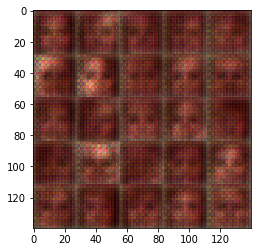

Epoch 1/1... Discriminator loss:1.5603... Generator loss:0.4380
Epoch 1/1... Discriminator loss:0.8971... Generator loss:1.2162
Epoch 1/1... Discriminator loss:1.0480... Generator loss:1.2400
Epoch 1/1... Discriminator loss:1.3185... Generator loss:0.7044
Epoch 1/1... Discriminator loss:1.4955... Generator loss:0.8392
Epoch 1/1... Discriminator loss:1.8731... Generator loss:0.2511
Epoch 1/1... Discriminator loss:0.9007... Generator loss:2.1037
Epoch 1/1... Discriminator loss:0.8672... Generator loss:1.2125
Epoch 1/1... Discriminator loss:0.8909... Generator loss:1.0602
Epoch 1/1... Discriminator loss:1.3996... Generator loss:0.4560


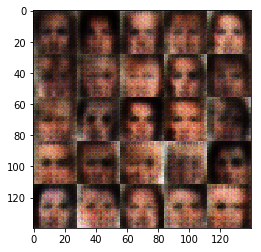

Epoch 1/1... Discriminator loss:1.3096... Generator loss:0.5851
Epoch 1/1... Discriminator loss:0.8896... Generator loss:1.0949
Epoch 1/1... Discriminator loss:1.6063... Generator loss:0.3568
Epoch 1/1... Discriminator loss:1.1468... Generator loss:0.8286
Epoch 1/1... Discriminator loss:0.8861... Generator loss:1.0581
Epoch 1/1... Discriminator loss:1.3814... Generator loss:0.6368
Epoch 1/1... Discriminator loss:1.3365... Generator loss:0.5705
Epoch 1/1... Discriminator loss:1.3770... Generator loss:0.8927
Epoch 1/1... Discriminator loss:1.4810... Generator loss:0.7304
Epoch 1/1... Discriminator loss:1.5410... Generator loss:0.9242


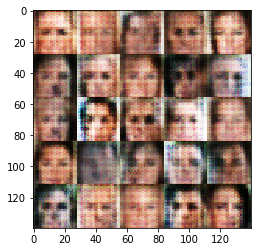

Epoch 1/1... Discriminator loss:1.2198... Generator loss:0.6270
Epoch 1/1... Discriminator loss:1.3604... Generator loss:1.0689
Epoch 1/1... Discriminator loss:1.2776... Generator loss:0.7929
Epoch 1/1... Discriminator loss:1.1190... Generator loss:0.9311
Epoch 1/1... Discriminator loss:1.4250... Generator loss:0.5179
Epoch 1/1... Discriminator loss:1.5391... Generator loss:1.1293
Epoch 1/1... Discriminator loss:1.1367... Generator loss:1.0012
Epoch 1/1... Discriminator loss:1.2809... Generator loss:0.7402
Epoch 1/1... Discriminator loss:1.2591... Generator loss:0.8620
Epoch 1/1... Discriminator loss:1.5830... Generator loss:0.5243


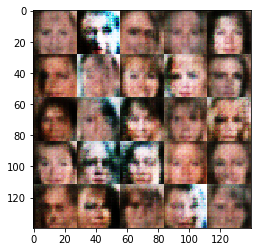

Epoch 1/1... Discriminator loss:1.2675... Generator loss:1.6311
Epoch 1/1... Discriminator loss:1.2471... Generator loss:1.0674
Epoch 1/1... Discriminator loss:1.4798... Generator loss:1.1494
Epoch 1/1... Discriminator loss:1.2400... Generator loss:1.4398
Epoch 1/1... Discriminator loss:1.4165... Generator loss:0.5089
Epoch 1/1... Discriminator loss:1.2501... Generator loss:0.7227
Epoch 1/1... Discriminator loss:1.7948... Generator loss:0.3546
Epoch 1/1... Discriminator loss:1.2115... Generator loss:0.8243
Epoch 1/1... Discriminator loss:1.0087... Generator loss:1.2972
Epoch 1/1... Discriminator loss:1.2804... Generator loss:0.6674


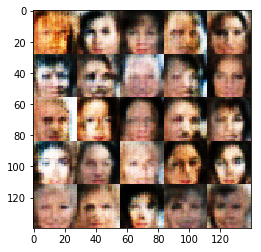

Epoch 1/1... Discriminator loss:1.1738... Generator loss:0.8650
Epoch 1/1... Discriminator loss:1.2186... Generator loss:0.6565
Epoch 1/1... Discriminator loss:1.2311... Generator loss:0.5616
Epoch 1/1... Discriminator loss:1.2473... Generator loss:0.6485
Epoch 1/1... Discriminator loss:1.5200... Generator loss:0.3704
Epoch 1/1... Discriminator loss:1.1416... Generator loss:0.8953
Epoch 1/1... Discriminator loss:1.0623... Generator loss:0.7075
Epoch 1/1... Discriminator loss:1.5499... Generator loss:1.7902
Epoch 1/1... Discriminator loss:1.2387... Generator loss:1.3198
Epoch 1/1... Discriminator loss:1.2689... Generator loss:0.6912


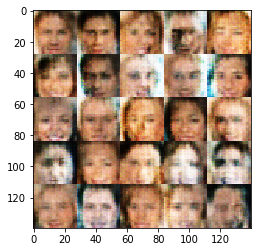

Epoch 1/1... Discriminator loss:1.2863... Generator loss:0.8134
Epoch 1/1... Discriminator loss:1.1016... Generator loss:1.6298
Epoch 1/1... Discriminator loss:1.1350... Generator loss:0.6821
Epoch 1/1... Discriminator loss:1.0631... Generator loss:0.7984
Epoch 1/1... Discriminator loss:1.3103... Generator loss:0.5068
Epoch 1/1... Discriminator loss:1.0917... Generator loss:0.7759
Epoch 1/1... Discriminator loss:0.9572... Generator loss:0.9487
Epoch 1/1... Discriminator loss:1.2749... Generator loss:0.6320
Epoch 1/1... Discriminator loss:1.5630... Generator loss:0.3521
Epoch 1/1... Discriminator loss:1.1350... Generator loss:0.9745


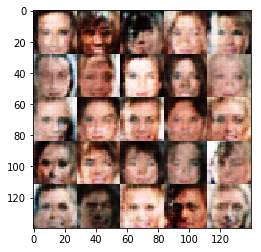

Epoch 1/1... Discriminator loss:1.0656... Generator loss:0.9648
Epoch 1/1... Discriminator loss:1.6241... Generator loss:0.3273
Epoch 1/1... Discriminator loss:1.2228... Generator loss:0.6133
Epoch 1/1... Discriminator loss:1.1762... Generator loss:0.6854
Epoch 1/1... Discriminator loss:1.1157... Generator loss:0.9036
Epoch 1/1... Discriminator loss:1.3350... Generator loss:1.5054
Epoch 1/1... Discriminator loss:1.1409... Generator loss:0.6970
Epoch 1/1... Discriminator loss:1.3660... Generator loss:0.8041
Epoch 1/1... Discriminator loss:1.0321... Generator loss:0.8635
Epoch 1/1... Discriminator loss:1.3457... Generator loss:0.5073


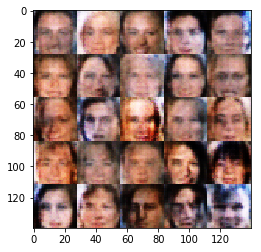

Epoch 1/1... Discriminator loss:1.3513... Generator loss:0.4711
Epoch 1/1... Discriminator loss:1.1963... Generator loss:0.5781
Epoch 1/1... Discriminator loss:1.2560... Generator loss:0.5644
Epoch 1/1... Discriminator loss:1.1420... Generator loss:0.7800
Epoch 1/1... Discriminator loss:1.3738... Generator loss:1.3221
Epoch 1/1... Discriminator loss:1.1124... Generator loss:0.9054
Epoch 1/1... Discriminator loss:1.1066... Generator loss:0.8163
Epoch 1/1... Discriminator loss:1.0026... Generator loss:0.8420
Epoch 1/1... Discriminator loss:1.1051... Generator loss:0.7293
Epoch 1/1... Discriminator loss:1.0429... Generator loss:1.4199


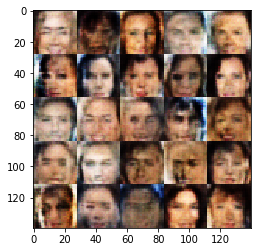

Epoch 1/1... Discriminator loss:1.2692... Generator loss:0.5284
Epoch 1/1... Discriminator loss:1.0801... Generator loss:1.4449
Epoch 1/1... Discriminator loss:1.2105... Generator loss:1.0142
Epoch 1/1... Discriminator loss:1.1718... Generator loss:1.1664
Epoch 1/1... Discriminator loss:1.1187... Generator loss:0.5985
Epoch 1/1... Discriminator loss:1.0552... Generator loss:0.9398
Epoch 1/1... Discriminator loss:1.1992... Generator loss:1.3666
Epoch 1/1... Discriminator loss:1.2613... Generator loss:0.5176
Epoch 1/1... Discriminator loss:1.1475... Generator loss:0.6864
Epoch 1/1... Discriminator loss:1.1941... Generator loss:0.7466


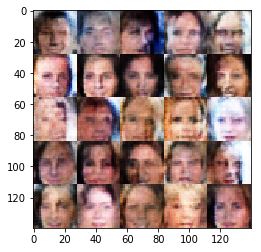

Epoch 1/1... Discriminator loss:1.1420... Generator loss:1.4686
Epoch 1/1... Discriminator loss:1.2259... Generator loss:0.9754
Epoch 1/1... Discriminator loss:1.0882... Generator loss:0.6865
Epoch 1/1... Discriminator loss:1.1817... Generator loss:0.9341
Epoch 1/1... Discriminator loss:1.0395... Generator loss:1.7423
Epoch 1/1... Discriminator loss:1.2166... Generator loss:0.4935
Epoch 1/1... Discriminator loss:0.9890... Generator loss:0.9685
Epoch 1/1... Discriminator loss:1.1951... Generator loss:0.6603
Epoch 1/1... Discriminator loss:1.5743... Generator loss:0.3757
Epoch 1/1... Discriminator loss:1.2354... Generator loss:0.5763


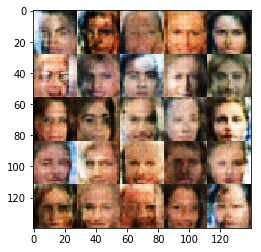

Epoch 1/1... Discriminator loss:1.2605... Generator loss:0.6490
Epoch 1/1... Discriminator loss:1.2057... Generator loss:0.5763
Epoch 1/1... Discriminator loss:1.4145... Generator loss:0.4326
Epoch 1/1... Discriminator loss:1.0576... Generator loss:1.1985
Epoch 1/1... Discriminator loss:1.4279... Generator loss:0.4733
Epoch 1/1... Discriminator loss:1.0085... Generator loss:0.8495
Epoch 1/1... Discriminator loss:1.3708... Generator loss:0.6332
Epoch 1/1... Discriminator loss:1.3064... Generator loss:0.4936
Epoch 1/1... Discriminator loss:1.3241... Generator loss:0.8575
Epoch 1/1... Discriminator loss:1.2402... Generator loss:0.7022


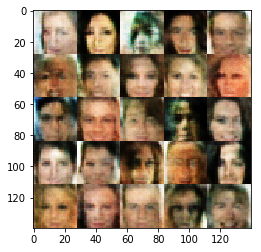

Epoch 1/1... Discriminator loss:1.1805... Generator loss:0.7310
Epoch 1/1... Discriminator loss:1.1099... Generator loss:0.6744
Epoch 1/1... Discriminator loss:1.4278... Generator loss:0.3871
Epoch 1/1... Discriminator loss:1.3191... Generator loss:0.5292
Epoch 1/1... Discriminator loss:1.1484... Generator loss:0.6539
Epoch 1/1... Discriminator loss:1.3508... Generator loss:1.2279
Epoch 1/1... Discriminator loss:1.1426... Generator loss:0.5865
Epoch 1/1... Discriminator loss:0.9470... Generator loss:1.2372
Epoch 1/1... Discriminator loss:1.0659... Generator loss:0.8121
Epoch 1/1... Discriminator loss:1.1585... Generator loss:0.6496


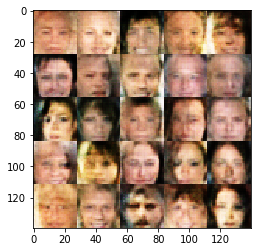

Epoch 1/1... Discriminator loss:1.1339... Generator loss:1.0462
Epoch 1/1... Discriminator loss:0.9673... Generator loss:0.7548
Epoch 1/1... Discriminator loss:0.9688... Generator loss:1.0486
Epoch 1/1... Discriminator loss:1.3575... Generator loss:0.4094
Epoch 1/1... Discriminator loss:1.1063... Generator loss:0.5885
Epoch 1/1... Discriminator loss:1.0863... Generator loss:0.8974
Epoch 1/1... Discriminator loss:1.0783... Generator loss:0.8555
Epoch 1/1... Discriminator loss:1.1708... Generator loss:0.8342
Epoch 1/1... Discriminator loss:1.1055... Generator loss:0.7642
Epoch 1/1... Discriminator loss:1.1032... Generator loss:0.6986


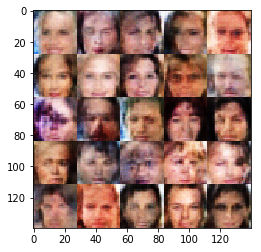

Epoch 1/1... Discriminator loss:0.8160... Generator loss:1.2653
Epoch 1/1... Discriminator loss:1.1313... Generator loss:0.7834
Epoch 1/1... Discriminator loss:1.2207... Generator loss:0.6736
Epoch 1/1... Discriminator loss:1.1830... Generator loss:1.1262
Epoch 1/1... Discriminator loss:1.2078... Generator loss:0.8427
Epoch 1/1... Discriminator loss:1.3989... Generator loss:0.4424
Epoch 1/1... Discriminator loss:1.4231... Generator loss:1.0496
Epoch 1/1... Discriminator loss:1.0027... Generator loss:1.0158
Epoch 1/1... Discriminator loss:1.0712... Generator loss:0.8971
Epoch 1/1... Discriminator loss:1.0993... Generator loss:1.0077


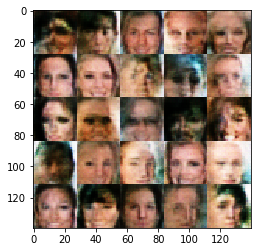

Epoch 1/1... Discriminator loss:1.2242... Generator loss:0.8376
Epoch 1/1... Discriminator loss:1.1053... Generator loss:0.6961
Epoch 1/1... Discriminator loss:1.1930... Generator loss:0.5388
Epoch 1/1... Discriminator loss:1.0679... Generator loss:1.0535
Epoch 1/1... Discriminator loss:1.1678... Generator loss:0.7017
Epoch 1/1... Discriminator loss:2.1467... Generator loss:0.1588
Epoch 1/1... Discriminator loss:1.0928... Generator loss:0.6140
Epoch 1/1... Discriminator loss:1.2675... Generator loss:0.5138
Epoch 1/1... Discriminator loss:1.0649... Generator loss:0.8216
Epoch 1/1... Discriminator loss:1.1286... Generator loss:0.6757


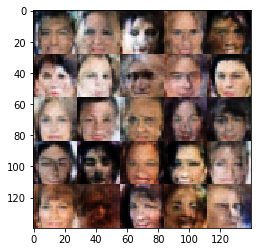

Epoch 1/1... Discriminator loss:1.1862... Generator loss:1.1292
Epoch 1/1... Discriminator loss:1.1098... Generator loss:1.0440
Epoch 1/1... Discriminator loss:1.2087... Generator loss:0.6049
Epoch 1/1... Discriminator loss:1.1399... Generator loss:0.5868
Epoch 1/1... Discriminator loss:1.0495... Generator loss:0.8808
Epoch 1/1... Discriminator loss:1.5006... Generator loss:0.3602
Epoch 1/1... Discriminator loss:1.1662... Generator loss:0.7666
Epoch 1/1... Discriminator loss:1.0176... Generator loss:1.1108
Epoch 1/1... Discriminator loss:1.3988... Generator loss:1.6969
Epoch 1/1... Discriminator loss:0.9484... Generator loss:1.0479


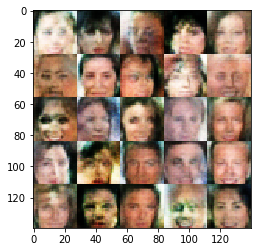

Epoch 1/1... Discriminator loss:1.2702... Generator loss:1.1359
Epoch 1/1... Discriminator loss:1.0220... Generator loss:0.8082
Epoch 1/1... Discriminator loss:1.1324... Generator loss:0.6479
Epoch 1/1... Discriminator loss:0.9704... Generator loss:0.6807
Epoch 1/1... Discriminator loss:1.0716... Generator loss:1.2841
Epoch 1/1... Discriminator loss:1.1110... Generator loss:0.6898
Epoch 1/1... Discriminator loss:1.3162... Generator loss:0.8267
Epoch 1/1... Discriminator loss:1.1185... Generator loss:0.6793
Epoch 1/1... Discriminator loss:0.9383... Generator loss:0.9515
Epoch 1/1... Discriminator loss:1.0333... Generator loss:1.0383


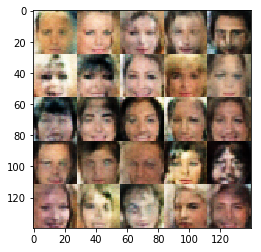

Epoch 1/1... Discriminator loss:1.3554... Generator loss:0.4332
Epoch 1/1... Discriminator loss:1.5088... Generator loss:0.3461
Epoch 1/1... Discriminator loss:1.0822... Generator loss:0.8455
Epoch 1/1... Discriminator loss:1.0894... Generator loss:1.2838
Epoch 1/1... Discriminator loss:1.1125... Generator loss:0.8100
Epoch 1/1... Discriminator loss:1.1313... Generator loss:0.6459
Epoch 1/1... Discriminator loss:1.2027... Generator loss:0.5023
Epoch 1/1... Discriminator loss:1.0128... Generator loss:0.8144
Epoch 1/1... Discriminator loss:1.0918... Generator loss:0.7404
Epoch 1/1... Discriminator loss:1.0173... Generator loss:0.7127


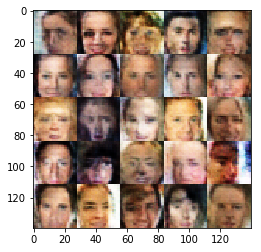

Epoch 1/1... Discriminator loss:1.1938... Generator loss:0.5376
Epoch 1/1... Discriminator loss:1.0163... Generator loss:1.2278
Epoch 1/1... Discriminator loss:1.0818... Generator loss:1.3212
Epoch 1/1... Discriminator loss:1.1850... Generator loss:0.5400
Epoch 1/1... Discriminator loss:1.0348... Generator loss:0.6396
Epoch 1/1... Discriminator loss:1.2513... Generator loss:0.7607
Epoch 1/1... Discriminator loss:0.9873... Generator loss:0.9908
Epoch 1/1... Discriminator loss:1.0802... Generator loss:0.9244
Epoch 1/1... Discriminator loss:1.0222... Generator loss:1.2500
Epoch 1/1... Discriminator loss:1.0194... Generator loss:1.3538


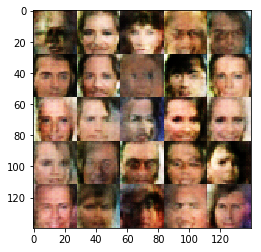

Epoch 1/1... Discriminator loss:1.4746... Generator loss:0.4068
Epoch 1/1... Discriminator loss:1.0888... Generator loss:0.6680
Epoch 1/1... Discriminator loss:1.1289... Generator loss:0.6793
Epoch 1/1... Discriminator loss:1.5992... Generator loss:0.3196
Epoch 1/1... Discriminator loss:1.1305... Generator loss:1.4819
Epoch 1/1... Discriminator loss:1.3891... Generator loss:0.4051
Epoch 1/1... Discriminator loss:1.2364... Generator loss:0.5916
Epoch 1/1... Discriminator loss:1.5581... Generator loss:0.3358
Epoch 1/1... Discriminator loss:1.0460... Generator loss:0.6712
Epoch 1/1... Discriminator loss:1.0718... Generator loss:0.7636


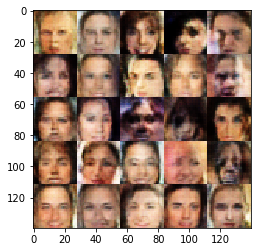

Epoch 1/1... Discriminator loss:0.9005... Generator loss:1.2579
Epoch 1/1... Discriminator loss:1.1700... Generator loss:0.6471
Epoch 1/1... Discriminator loss:1.1130... Generator loss:0.6640
Epoch 1/1... Discriminator loss:1.0298... Generator loss:0.9266
Epoch 1/1... Discriminator loss:1.0998... Generator loss:0.7314
Epoch 1/1... Discriminator loss:1.0905... Generator loss:1.0996
Epoch 1/1... Discriminator loss:1.2464... Generator loss:1.7847
Epoch 1/1... Discriminator loss:1.1503... Generator loss:0.8687
Epoch 1/1... Discriminator loss:1.1289... Generator loss:0.8084
Epoch 1/1... Discriminator loss:1.2390... Generator loss:0.4486


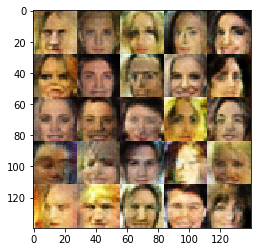

Epoch 1/1... Discriminator loss:1.2981... Generator loss:0.8837
Epoch 1/1... Discriminator loss:1.0256... Generator loss:1.0080
Epoch 1/1... Discriminator loss:1.1200... Generator loss:0.8159
Epoch 1/1... Discriminator loss:1.5301... Generator loss:0.3242
Epoch 1/1... Discriminator loss:1.1120... Generator loss:0.8587
Epoch 1/1... Discriminator loss:1.2924... Generator loss:0.5227
Epoch 1/1... Discriminator loss:1.1897... Generator loss:0.6703
Epoch 1/1... Discriminator loss:1.0675... Generator loss:0.6629
Epoch 1/1... Discriminator loss:1.4143... Generator loss:0.3993
Epoch 1/1... Discriminator loss:1.2827... Generator loss:0.5834


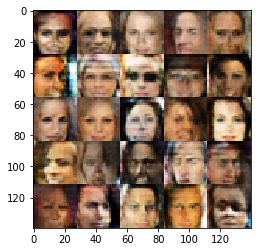

Epoch 1/1... Discriminator loss:1.4926... Generator loss:1.2265
Epoch 1/1... Discriminator loss:1.1776... Generator loss:0.5017
Epoch 1/1... Discriminator loss:1.0275... Generator loss:0.7621
Epoch 1/1... Discriminator loss:1.0465... Generator loss:1.0303
Epoch 1/1... Discriminator loss:0.9080... Generator loss:0.9023
Epoch 1/1... Discriminator loss:1.0281... Generator loss:1.0628
Epoch 1/1... Discriminator loss:1.2117... Generator loss:0.8465
Epoch 1/1... Discriminator loss:0.9211... Generator loss:1.3615
Epoch 1/1... Discriminator loss:1.2354... Generator loss:1.4299
Epoch 1/1... Discriminator loss:1.3310... Generator loss:0.4358


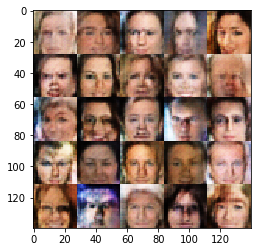

Epoch 1/1... Discriminator loss:1.2483... Generator loss:0.4872
Epoch 1/1... Discriminator loss:1.1261... Generator loss:0.5563
Epoch 1/1... Discriminator loss:0.9799... Generator loss:1.1030
Epoch 1/1... Discriminator loss:1.1735... Generator loss:1.1505
Epoch 1/1... Discriminator loss:1.0182... Generator loss:1.1133
Epoch 1/1... Discriminator loss:1.2286... Generator loss:0.5061
Epoch 1/1... Discriminator loss:1.0425... Generator loss:0.8755
Epoch 1/1... Discriminator loss:1.1955... Generator loss:1.1584
Epoch 1/1... Discriminator loss:1.0733... Generator loss:1.5768
Epoch 1/1... Discriminator loss:1.0323... Generator loss:1.0438


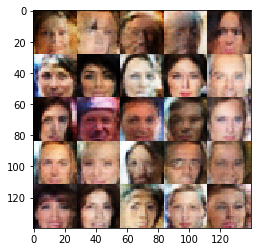

Epoch 1/1... Discriminator loss:1.1391... Generator loss:1.2188
Epoch 1/1... Discriminator loss:1.4421... Generator loss:0.3846
Epoch 1/1... Discriminator loss:1.1826... Generator loss:0.9072
Epoch 1/1... Discriminator loss:1.1984... Generator loss:1.1045
Epoch 1/1... Discriminator loss:1.2319... Generator loss:0.5352
Epoch 1/1... Discriminator loss:1.2859... Generator loss:1.2894
Epoch 1/1... Discriminator loss:1.0503... Generator loss:1.0927
Epoch 1/1... Discriminator loss:1.3066... Generator loss:0.5465
Epoch 1/1... Discriminator loss:0.9629... Generator loss:1.3206
Epoch 1/1... Discriminator loss:1.0840... Generator loss:1.5734


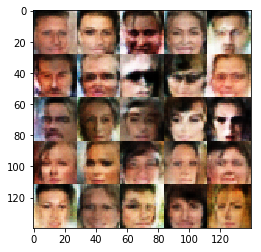

Epoch 1/1... Discriminator loss:0.9807... Generator loss:0.7838
Epoch 1/1... Discriminator loss:0.8518... Generator loss:0.9416
Epoch 1/1... Discriminator loss:1.2150... Generator loss:1.0341
Epoch 1/1... Discriminator loss:1.2016... Generator loss:0.5546
Epoch 1/1... Discriminator loss:1.1542... Generator loss:0.6553
Epoch 1/1... Discriminator loss:1.0401... Generator loss:0.8205
Epoch 1/1... Discriminator loss:1.1537... Generator loss:1.2211
Epoch 1/1... Discriminator loss:1.1609... Generator loss:0.5929
Epoch 1/1... Discriminator loss:1.0475... Generator loss:0.9175
Epoch 1/1... Discriminator loss:1.0764... Generator loss:1.0176


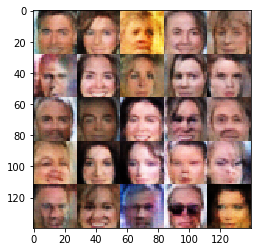

Epoch 1/1... Discriminator loss:1.5181... Generator loss:0.3303
Epoch 1/1... Discriminator loss:1.0354... Generator loss:0.8964
Epoch 1/1... Discriminator loss:1.1712... Generator loss:1.1841
Epoch 1/1... Discriminator loss:1.2077... Generator loss:0.7731
Epoch 1/1... Discriminator loss:0.9234... Generator loss:1.0626
Epoch 1/1... Discriminator loss:1.0344... Generator loss:0.6923
Epoch 1/1... Discriminator loss:1.1098... Generator loss:0.7318
Epoch 1/1... Discriminator loss:1.0747... Generator loss:0.8570
Epoch 1/1... Discriminator loss:1.5627... Generator loss:0.3449
Epoch 1/1... Discriminator loss:1.4049... Generator loss:1.1714


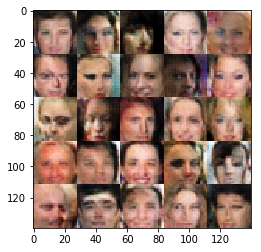

Epoch 1/1... Discriminator loss:1.5241... Generator loss:0.3622
Epoch 1/1... Discriminator loss:1.0928... Generator loss:0.8971
Epoch 1/1... Discriminator loss:1.1297... Generator loss:0.7273
Epoch 1/1... Discriminator loss:1.0054... Generator loss:0.9197
Epoch 1/1... Discriminator loss:1.0351... Generator loss:0.7436
Epoch 1/1... Discriminator loss:0.9746... Generator loss:0.8495
Epoch 1/1... Discriminator loss:1.0911... Generator loss:0.8703
Epoch 1/1... Discriminator loss:0.9491... Generator loss:0.9318
Epoch 1/1... Discriminator loss:1.1942... Generator loss:0.6486
Epoch 1/1... Discriminator loss:1.1257... Generator loss:1.2009


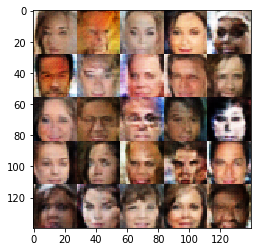

Epoch 1/1... Discriminator loss:1.2959... Generator loss:0.4822
Epoch 1/1... Discriminator loss:1.0606... Generator loss:1.1633
Epoch 1/1... Discriminator loss:1.3087... Generator loss:0.7930
Epoch 1/1... Discriminator loss:1.1948... Generator loss:0.6847
Epoch 1/1... Discriminator loss:1.5169... Generator loss:0.3313
Epoch 1/1... Discriminator loss:1.5229... Generator loss:0.3295
Epoch 1/1... Discriminator loss:1.0297... Generator loss:0.8772
Epoch 1/1... Discriminator loss:1.0752... Generator loss:1.3661
Epoch 1/1... Discriminator loss:1.4730... Generator loss:0.3705
Epoch 1/1... Discriminator loss:0.9935... Generator loss:0.7618


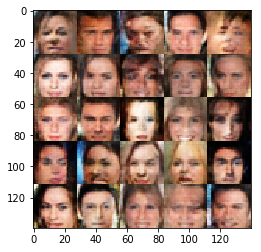

Epoch 1/1... Discriminator loss:1.0057... Generator loss:0.8073
Epoch 1/1... Discriminator loss:1.1955... Generator loss:1.0997
Epoch 1/1... Discriminator loss:1.3879... Generator loss:0.4237
Epoch 1/1... Discriminator loss:1.1983... Generator loss:1.2926
Epoch 1/1... Discriminator loss:1.0392... Generator loss:0.8438
Epoch 1/1... Discriminator loss:0.9974... Generator loss:0.8304
Epoch 1/1... Discriminator loss:1.1647... Generator loss:0.9293
Epoch 1/1... Discriminator loss:1.3261... Generator loss:0.4971
Epoch 1/1... Discriminator loss:1.0290... Generator loss:0.9496
Epoch 1/1... Discriminator loss:1.0101... Generator loss:0.8635


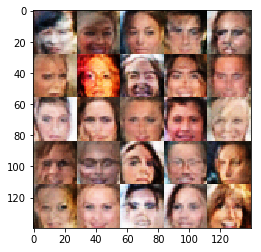

Epoch 1/1... Discriminator loss:1.0986... Generator loss:0.6111
Epoch 1/1... Discriminator loss:1.0697... Generator loss:1.4866
Epoch 1/1... Discriminator loss:1.1296... Generator loss:0.6886
Epoch 1/1... Discriminator loss:1.1672... Generator loss:0.6901
Epoch 1/1... Discriminator loss:1.3955... Generator loss:0.4409
Epoch 1/1... Discriminator loss:1.1468... Generator loss:0.7546


In [69]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.